In [1]:
import nbimporter
import numpy as np
from math import ceil

from s02_01_b_heat_conversion_coefficient import get_f_prim
from s02_02_design_primary_energy_consumption import get_E_T_star, calc_E_H, calc_E_C, calc_E_W, calc_E_L, calc_E_V, calc_E_M, calc_heating_load, calc_cooling_load, \
    get_virtual_heating_devices, get_virtual_heatsource, calc_heating_mode, calc_L_HWH, calc_E_E, calc_E_G, calc_E_K, \
    calc_E_UT_H, calc_E_S, get_E_E_CG_h
from s02_03_standard_primary_energy_consumption import get_E_ST_star, calc_E_SH, calc_E_SC, calc_E_SV, calc_E_SW, calc_E_SL, calc_E_SM
from s03_01_hc_load_general import get_Q
from s03_02_envelope_performance import calc_insulation_performance
from s07_01_b_types_and_specifications_of_equipment import get_virtual_hotwater


# 第二章　単位住戸の一次エネルギー消費量 / Chapter 2 Designed Primary Energy Consumption

## 第一節　全般 / Section 1 General

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

### 5．住戸の床面積並びに主たる居室、その他の居室及び非居室の定義 / Floor area of dwelling unit and definition of main living room, other living room and non-living room

省略

Omission

### 6．電気の量 1kWh を熱量に換算する係数 / A factor to convert 1kWh of electricity into heat

省略

Omission

### 7．仮想居住人数 / Virtual number of people

省略

Omission

### 8．設計一次エネルギー消費量 / Design primary energy consumption

$$
\large 
E_{T} = E_{T}^* \times 10^{-3}
$$

In [2]:
def calc_E_T(spec):
    """設計一次エネルギー消費量[GJ/年]を計算する

    :param spec: 住戸についての詳細なデータ
    :type spec: dict
    :return: 1年当たりの各消費量 E_T, E_H, E_C, E_V, E_L, E_W, E_S, E_M, UPL, E_gen, E_E_gen, E_E_PV_h_d_t, E_E, E_G, E_K (15 variables)
    :rtype: tuple
    """
    E_H = None
    E_C = None
    E_W = None
    E_L = None
    E_V = None
    E_M = None
    E_gen = None
    E_E_gen = None
    E_S = None

    E_E = None
    E_G = None
    E_K = None
    UPL = None

    # ---- 事前データ読み込み ----

    # 日射量データの読み込み
    from s11_02_solar_radiation import load_solrad
    from s09_01_pv_system import calc_E_E_PV_d_t

    solrad = None
    if (spec['SHC'] is not None or spec['PV'] is not None) and 'sol_region' in spec:
        if spec['sol_region'] is not None:
            solrad = load_solrad(spec['region'], spec['sol_region'])

#     # ハイブリッド給湯機の仕様読み込み
#     if spec['HW'] is not None and 'package_id' in spec['HW']:
#         import section7_1_g_3
#         section7_1_g_3.load_specification('HybridWaterHeater_package_list_TestCaseTest_sample.csv')

    # ---- 外皮の計算 ----

    # 外皮の断熱性能の計算
    if spec['ENV'] is not None:
        U_A, _, _, _, Q_dash, eta_H, eta_C, _ = calc_insulation_performance(**spec['ENV'])
        # 熱損失係数
        Q = get_Q(Q_dash)
        A_env = spec['ENV'].get('A_env')
    else:
        Q = None
        eta_H, eta_C = None, None
        A_env = None

    # ---- 暖房設備 ----

    # 1 時間当たりの暖房設備の設計一次エネルギー消費量

    # 実質的な暖房機器の仕様を取得
    spec_MR, spec_OR = get_virtual_heating_devices(spec['region'], spec['H_MR'], spec['H_OR'])

    # 暖房方式及び運転方法の区分
    mode_MR, mode_OR = calc_heating_mode(region=spec['region'], H_MR=spec_MR, H_OR=spec_OR)

    # ---- 暖房負荷 ----

    # 暖房負荷の取得
    L_T_H_d_t_i, L_dash_H_R_d_t_i = calc_heating_load(
        spec['region'], spec['sol_region'],
        spec['A_A'], spec['A_MR'], spec['A_OR'],
        Q, eta_H, eta_C, spec['NV_MR'], spec['NV_OR'], spec['TS'], spec['r_A_ufvnt'], spec['HEX'],
        spec['underfloor_insulation'], spec['mode_H'], spec['mode_C'],
        spec_MR, spec_OR, mode_MR, mode_OR, spec['SHC'])

    # ---- 冷房負荷 ----

    # 冷房負荷の取得
    L_CS_d_t, L_CL_d_t = \
        calc_cooling_load(spec['region'], spec['A_A'], spec['A_MR'], spec['A_OR'], Q, eta_H, eta_C,
                          spec['NV_MR'], spec['NV_OR'], spec['r_A_ufvnt'], spec['underfloor_insulation'],
                          spec['mode_C'], spec['mode_H'], mode_MR, mode_OR, spec['TS'], spec['HEX'])

    # ---- 冷房設備 ----

    # 1 年当たりの冷房設備の設計一次エネルギー消費量
    E_C = calc_E_C(spec['region'], spec['A_A'], spec['A_MR'], spec['A_OR'],
                  A_env, eta_H, eta_C, Q,
                  spec['C_A'], spec['C_MR'], spec['C_OR'],
                  L_T_H_d_t_i, L_CS_d_t, L_CL_d_t, spec['mode_C'])


    # ---- 暖房設備 ----

    # 1 時間当たりの暖房設備の設計一次エネルギー消費量

    # 実質的な温水暖房機の仕様を取得
    spec_HS = get_virtual_heatsource(spec['region'], spec['H_HS'])

    # 暖房日の計算
    if spec['SHC'] is not None and spec['SHC']['type'] == '空気集熱式':
        from s03_01_10_heating_day import get_heating_flag_d

        heating_flag_d = get_heating_flag_d(L_dash_H_R_d_t_i)
    else:
        heating_flag_d = None

    E_H = calc_E_H(spec['region'], spec['sol_region'], spec['A_A'], spec['A_MR'], spec['A_OR'],
                  A_env, eta_H, eta_C, Q,
                  spec['mode_H'],
                  spec['H_A'], spec_MR, spec_OR, spec_HS, mode_MR, mode_OR, spec['CG'], spec['SHC'],
                  heating_flag_d, L_T_H_d_t_i, L_CS_d_t, L_CL_d_t)

    # 暖房設備の未処理暖房負荷の設計一次エネルギー消費量相当値
    UPL = calc_E_UT_H(spec['region'], spec['A_A'], spec['A_MR'], spec['A_OR'], A_env, eta_H, eta_C, Q, spec['mode_H'],
                     spec['H_A'], spec_MR, spec_OR, spec_HS, mode_MR, mode_OR, spec['CG'],
                     L_T_H_d_t_i, L_CS_d_t, L_CL_d_t)
    UPL = np.sum(UPL)

    # 温水暖房負荷の計算
    L_HWH = calc_L_HWH(spec['A_A'], spec['A_MR'], spec['A_OR'], spec['HEX'], spec['H_HS'], spec['H_MR'],
                           spec['H_OR'], Q, spec['SHC'], spec['TS'], eta_H, eta_C, spec['NV_MR'], spec['NV_OR'],
                           spec['r_A_ufvnt'], spec['region'], spec['sol_region'], spec['underfloor_insulation'],
                           spec['CG'])

    # ---- 給湯/コージェネ設備 ----

    # その他または設置しない場合
    spec_HW = get_virtual_hotwater(spec['region'], spec['HW'])

    # 1 年当たりの給湯設備（コージェネレーション設備を含む）の設計一次エネルギー消費量
    E_W, E_E_CG_gen_d_t, _, E_E_TU_aux_d_t, E_E_CG_h_d_t, E_G_CG_ded, e_BB_ave, Q_CG_h \
            = calc_E_W(spec['A_A'], spec['region'], spec['sol_region'], spec_HW, spec['SHC'], spec['CG'],
                      spec['H_A'],
                      spec['H_MR'], spec['H_OR'], spec['H_HS'], spec['C_A'], spec['C_MR'], spec['C_OR'],
                      spec['V'],
                      spec['L'], spec['A_MR'], spec['A_OR'], A_env, Q, eta_H, eta_C,
                      spec['NV_MR'],
                      spec['NV_OR'], spec['TS'], spec['r_A_ufvnt'], spec['HEX'],
                      spec['underfloor_insulation'],
                      spec['mode_H'], spec['mode_C'])

    # ---- 照明,換気,その他設備 ----

    # 1 年当たりの照明設備の設計一次エネルギー消費量
    E_L = calc_E_L(spec['A_A'], spec['A_MR'], spec['A_OR'], spec['L'])

    # 1 年当たりの機械換気設備の設計一次エネルギー消費量
    E_V = calc_E_V(spec['A_A'], spec['V'], spec['HEX'])

    # 1年当たりのその他の設計一次エネルギー消費量
    E_M = calc_E_M(spec['A_A'])

    # ---- 二次エネの計算 ----

    # 1 年当たりの設計消費電力量（kWh/年）
    E_E, E_E_PV_h_d_t, E_E_PV_d_t, E_E_CG_gen_d_t, E_E_CG_h_d_t, E_E_dmd_d_t, E_E_TU_aux_d_t = \
                calc_E_E(spec['region'], spec['sol_region'], spec['A_A'], spec['A_MR'], spec['A_OR'],
                        A_env, spec_HW, Q, spec['TS'], eta_H, eta_C, spec['r_A_ufvnt'],
                        spec['underfloor_insulation'], spec['NV_MR'], spec['NV_OR'],
                        spec['mode_H'], spec['mode_C'],
                        spec['V'], spec['L'],
                        spec['H_A'], spec['H_MR'], spec['H_OR'], spec['H_HS'],
                        spec['CG'], spec['SHC'],
                        L_T_H_d_t_i,
                        spec['C_A'], spec['C_MR'], spec['C_OR'], L_T_H_d_t_i,
                        L_CS_d_t, L_CL_d_t,
                        spec['HEX'], spec['PV'], solrad
                        )
    f_prim = get_f_prim()
    E_gen = (np.sum(E_E_PV_d_t) + np.sum(E_E_CG_gen_d_t)) * f_prim / 1000

    # 1 年当たりの設計ガス消費量（MJ/年）
    E_G = calc_E_G(spec['region'], spec['sol_region'], spec['A_A'], spec['A_MR'], spec['A_OR'],
                          A_env, Q, eta_H, eta_C, spec['NV_MR'], spec['NV_OR'], spec['TS'],
                          spec['r_A_ufvnt'], spec['HEX'], spec['underfloor_insulation'],
                          spec['H_A'], spec['H_MR'], spec['H_OR'], spec['H_HS'], spec['C_A'], spec['C_MR'],
                          spec['C_OR'], spec['V'], spec['L'], spec_HW, spec['SHC'],
                          spec_MR, spec_OR, spec_HS, mode_MR, mode_OR, spec['mode_H'], spec['mode_C'],
                          spec['CG'],
                          L_T_H_d_t_i, L_HWH, heating_flag_d)

    # 1 年当たりの設計灯油消費量（MJ/年）
    E_K = calc_E_K(spec['region'], spec['sol_region'], spec['A_A'], spec['A_MR'], spec['A_OR'],
                          spec['H_A'],
                          spec_MR, spec_OR, spec_HS, mode_MR, mode_OR, spec['CG'],
                          L_T_H_d_t_i,
                          L_HWH, heating_flag_d, spec_HW, spec['SHC'])

    # ---- エネルギー利用効率化の評価 ----

    # エネルギー利用効率化設備による設計一次エネルギー消費量の削減量
    E_E_CG_h = get_E_E_CG_h(E_E_CG_h_d_t)
    E_S = calc_E_S(spec['region'], spec['sol_region'], spec['PV'], spec['CG'], E_E_dmd_d_t, E_E_CG_gen_d_t,
                   E_E_TU_aux_d_t, E_E_CG_h, E_G_CG_ded, e_BB_ave, Q_CG_h)

    E_E_gen = np.sum(calc_E_E_PV_d_t(spec['PV'], solrad) + E_E_CG_gen_d_t)

    # ---- 合計 ----

    E_T = get_E_T(E_H, E_C, E_V, E_L, E_W, E_S, E_M)

    return E_T, E_H, E_C, E_V, E_L, E_W, E_S, E_M, UPL, E_gen, E_E_gen, E_E_PV_h_d_t, E_E, E_G, E_K


In [3]:
def get_E_T(E_H, E_C, E_V, E_L, E_W, E_S, E_M):
    """各1 年当たりの設計一次エネルギー消費量を合計する
    
    :param E_H: 1 年当たりの暖房設備の設計一次エネルギー消費量（MJ/年）
    :type E_H: float
    :param E_C: 1 年当たりの冷房設備の設計一次エネルギー消費量
    :type E_C: float
    :param E_V: 1 年当たりの機械換気設備の設計一次エネルギー消費量
    :type E_V: float
    :param E_L: 1 年当たりの照明設備の設計一次エネルギー消費量
    :type E_L: float
    :param E_W: 1 年当たりの給湯設備（コージェネレーション設備を含む）の設計一次エネルギー消費量
    :type E_W: float
    :param E_S: 1 年当たりのエネルギー利用効率化設備による設計一次エネルギー消費量の削減量
    :type E_S: float
    :param E_M: 1 年当たりのその他の設計一次エネルギー消費量
    :type E_M: float
    :return: 1 年当たりの設計一次エネルギー消費量（GJ/年）
    :rtype: float
    """
    # 1 年当たりの設計一次エネルギー消費量（MJ/年）(s2-2-1)
    E_T_star = get_E_T_star(E_H, E_C, E_V, E_L, E_W, E_S, E_M)

    # 小数点以下一位未満の端数があるときはこれを切り上げてMJをGJに変更する
    E_T = ceil(E_T_star / 100) / 10  # (1)

    return E_T


$E_{T}$：設計一次エネルギー消費量(GJ/年) / Design primary energy consumption  
$E_{T}^*$：設計一次エネルギー消費量(MJ/年) / Design primary energy consumption  

設計一次エネルギー消費量$E_{T}$は、数値に小数点以下一位未満の端数があるときは、これを切り上げる。 

Design Primary Energy Consumption $ E_{T} $ is rounded up if the number has a fraction less than one decimal place.

### 9．基準一次エネルギー消費量 / Standard primary energy consumption

$$
\large 
E_{ST} = E_{ST}^* \times 10^{-3}
$$

In [4]:
def calc_E_ST(spec):
    """基準一次エネルギー消費量の計算
    
    :param spec: 住戸についての詳細なデータ
    :type spec: dict
    :return: 1年当たりの各消費量 E_ST, E_SH, E_SC, E_SV, E_SL, E_SW, E_SM (7 variables)
    :rtype: tuple
    """
    # 1年当たりの機械換気設備の基準一次エネルギー消費量
    E_SV = calc_E_SV(spec['A_A'])

    # 1 時間当たりの暖房設備の基準一次エネルギー消費量
    E_SH = calc_E_SH(spec['type'], spec['tatekata'], spec['region'], spec['reference'], spec['sol_region'], spec['A_A'],
                     spec['A_MR'], spec['A_OR'], spec['ENV'], spec['mode_H'], spec['mode_C'], spec['NV_MR'], spec['NV_OR'], spec['H_MR'], spec['H_OR'])

    # 1 時間当たりの冷房設備の基準一次エネルギー消費量
    E_SC = calc_E_SC(spec['type'], spec['tatekata'], spec['region'], spec['reference'], spec['A_A'], spec['A_MR'],
                     spec['A_OR'], spec['ENV'], spec['mode_C'], spec['mode_H'], spec['H_MR'], spec['H_OR'], spec['TS'], spec['HEX'],
                     spec['sol_region'], spec['NV_MR'], spec['NV_OR'])

    # 1年当たりの給湯設備の基準一次エネルギー消費量
    E_SW = calc_E_SW(spec['region'], spec['A_A'], spec['HW'])

    # 1年当たりの照明設備の基準一次エネルギー消費量
    E_SL = calc_E_SL(spec['A_A'], spec['A_MR'], spec['A_OR'])

    # 1年当たりのその他の基準一次エネルギー消費量
    E_SM = calc_E_SM(spec['A_A'])

    # 合計
    E_ST = get_E_ST(E_SH, E_SC, E_SV, E_SL, E_SW, E_SM, spec['reference'])

    return E_ST, E_SH, E_SC, E_SV, E_SL, E_SW, E_SM

In [5]:
# 基準一次エネルギー消費量（GJ/年）
def get_E_ST(E_SH, E_SC, E_SV, E_SL, E_SW, E_SM, reference):
    """基準一次エネルギー消費量（GJ/年）の取得

    :param E_SH: 1 時間当たりの暖房設備の基準一次エネルギー消費量
    :type E_SH: float
    :param E_SC: 1 時間当たりの冷房設備の基準一次エネルギー消費量
    :type E_SC: float
    :param E_SV: 1 時間当たりの換気設備の基準一次エネルギー消費量
    :type E_SV: float
    :param E_SL: 1 時間当たりの照明設備の基準一次エネルギー消費量
    :type E_SL: float
    :param E_SW: 1 時間当たりの給湯設備の基準一次エネルギー消費量
    :type E_SW: float
    :param E_SM: 1 時間当たりのその他の基準一次エネルギー消費量
    :type E_SM: float
    :param reference: 基準値計算仕様
    :type reference: dict
    :return: 基準一次エネルギー消費量（GJ/年）
    :rtype: float
    """
    # 小数点以下一位未満の端数があるときはこれを切り上げる

    return ceil(get_E_ST_star(E_SH, E_SC, E_SV, E_SL, E_SW, E_SM, reference) / 100) / 10  # (2)

$E_{ST}$：基準一次エネルギー消費量(GJ/年) / Standard primary energy consumption  
$E_{ST}^*$：基準一次エネルギー消費量(MJ/年) / Standard primary energy consumption  

基準一次エネルギー消費量$E_{ST}$は、数値に小数点以下一位未満の端数があるときは、これを切り上げる。

The standard primary energy consumption $ E_ {ST} $ is rounded up if there are fractions less than one decimal place in the number.

### 10．BEI (Building Energy Index）

$$
\large 
BEI = \frac{E'_{T}}{E'_{ST}}
$$

$$
\large 
E'_{T} = (E^*_{T} - E_{M}) / 1000
$$

$$
\large 
E'_{ST} = (E^*_{ST} - E_{SM}) / 1000
$$

In [6]:
# BEI(Building Energy Index）
def calc_BEI(E_H, E_C, E_V, E_L, E_W, E_S, E_M, E_SH, E_SC, E_SV, E_SL, E_SW, E_SM, reference):
    """BEI(Building Energy Index） の取得
    
    :param E_H: 1 年当たりの暖房設備の設計一次エネルギー消費量（MJ/年）
    :type E_H: float
    :param E_C: 1 年当たりの冷房設備の設計一次エネルギー消費量（MJ/年）
    :type E_C: float
    :param E_V: 1 年当たりの機械換気設備の設計一次エネルギー消費量（MJ/年）
    :type E_V: float
    :param E_L: 1 年当たりの照明設備の設計一次エネルギー消費量（MJ/年）
    :type E_L: float
    :param E_W: 1 年当たりの給湯設備（コージェネレーション設備を含む）の設計一次エネルギー消費量（MJ/年）
    :type E_W: float
    :param E_S: 1 年当たりのエネルギー利用効率化設備による設計一次エネルギー消費量の削減量（MJ/年）
    :type E_S: float
    :param E_M: 1 年当たりのその他の設計一次エネルギー消費量（MJ/年）
    :type E_M: float
    :param E_SH: 1 年当たりの暖房設備の基準一次エネルギー消費量（MJ/年）
    :type E_SH: float
    :param E_SC: 1 年当たりの冷房設備の基準一次エネルギー消費量（MJ/年）
    :type E_SC: float
    :param E_SV: 1 年当たりの機械換気設備の基準一次エネルギー消費量（MJ/年）
    :type E_SV: float
    :param E_SL: 1 年当たりの照明設備の基準一次エネルギー消費量（MJ/年）
    :type E_SL: float
    :param E_SW 1 年当たりの給湯設備（コージェネレーション設備を含む）の基準一次エネルギー消費量（MJ/年）
    :type E_SW: float
    :param E_SM: 1 年当たりのその他の基準一次エネルギー消費量（MJ/年）
    :type E_SM: float
    :param result_type: 基準値計算仕様
    :type result_type: dict
    :return: BEI(Building Energy Index）
    :rtype: float
    """
    # 設計一次エネルギー消費量（MJ/年）
    E_star_T = get_E_T_star(E_H, E_C, E_V, E_L, E_W, E_S, E_M)
    
    # 2020/02/13
    # 基準値計算タイプについて仕様書とはずれるが、C#に合わせて一旦全て'建築物エネルギー消費性能基準（H28 年 4 月以降）'で計算
    reference['result_type'] = '建築物エネルギー消費性能基準（H28 年 4 月以降）'

    # 基準一次エネルギー消費量（MJ/年）
    E_star_ST = get_E_ST_star(E_SH, E_SC, E_SV, E_SL, E_SW, E_SM, reference)

    # 小数点以下一位未満の端数があるときはこれを切り上げる
    E_T_dash = ceil((E_star_T - E_M) / 100) / 10  # (3-2)
    E_ST_dash = ceil((E_star_ST - E_SM) / 100) / 10  # (3-3)
    # 小数点以下二位未満の端数があるときはこれを切り上げる
    BEI = ceil(E_T_dash / E_ST_dash * 100) / 100  # (3-1)
    return BEI


$BEI$：Building Energy Index(-)  
$E_{ST}^*$：基準一次エネルギー消費量(MJ/年) / Standard primary energy consumption  
$E'_{ST}$：その他の基準一次エネルギー消費量を除いた基準一次エネルギー消費量(GJ/年) / Other criteria Primary energy consumption excluding primary energy consumption  
$E_{SM}$：1 年当たりのその他の基準一次エネルギー消費量(MJ/年) / Other baseline primary energy consumption per year  
$E_{T}^*$：設計一次エネルギー消費量(MJ/年) / Design primary energy consumption  
$E'_{T}$：その他の設計一次エネルギー消費量を除いた設計一次エネルギー消費量(GJ/年) / Other design primary energy consumption excluding primary energy consumption  
$E_{M}$：1 年当たりのその他の設計一次エネルギー消費量(MJ/年) / Other design primary energy consumption per year  

その他の基準一次エネルギー消費量を除いた基準一次エネルギー消費量$E'_{ST}$ およびその他の設計一次エネルギー消費量を除いた設計一次エネルギー消費量$E'_{T}$は、数値に小数点以下一位未満の端数があるときは、これを切り上げる。$BEI$は、数値に小数点以下二位未満の端数があるときは、これを切り上げる。

Other criteria Primary energy consumption $ E'_{ST} $ excluding primary energy consumption and design primary energy consumption $ E'_{T} $ excluding other design primary energy consumption are numerical values If there is a fraction less than one decimal place in, round it up. $ BEI $ rounds up if the number has a fraction less than two decimal places.

## 付録 A 「主たる居室」、「その他の居室」及び「非居室」の定義並びに各床面積及び床面積の合計の算出方法 / Appendix A Definitions of "main room", "other rooms" and "non-rooms" and calculation method of total floor area and total floor area

省略

Omission

# 試算例

In [7]:
def get_default_house():
    
    house = {
        # 基本情報
        'type': '一般住宅',
        'tatekata': '戸建住宅',
        'result_type': '建築物エネルギー消費性能基準（H28 年 4 月以降）',
        'A_A': 120.08,
        'A_MR': 29.81,
        'A_OR': 51.34,
        'region': 6,
        'sol_region': None,
        'reference': {'result_type': '建築物エネルギー消費性能基準（H28 年 4 月以降）', 'reference_year': 'H28'},

        # 外皮
        'ENV': {"A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8,
                'method': '当該住宅の外皮面積の合計を用いて評価する', 'U_spec': None},
        "NV_MR": 0, "NV_OR": 0,

        'r_A_ufvnt': None,
        'HEX': None,
        'underfloor_insulation': False,
        'TS': None,

        # 暖房
        'mode_H': '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合',
        'H_MR': {'type': 'ルームエアコンディショナー', 'e_class': 'は', 'dualcompressor': False},
        'H_OR': {'type': 'ルームエアコンディショナー', 'e_class': 'は', 'dualcompressor': False},
        'H_A': None,
        'H_HS': None,

        # 冷房
        'mode_C': '居室のみを冷房する方式',
        'C_A': None,
        'C_MR': {"type": "ルームエアコンディショナー", 'e_class': 'は', 'dualcompressor': False},
        'C_OR': {'type': 'ルームエアコンディショナー', 'e_class': 'は', 'dualcompressor': False},

        # 換気
        'V': {'type': 'ダクト式第二種換気設備又はダクト式第三種換気設備',
              'input': '比消費電力', 'f_SFP': 0.30, 'v_e': None, 'N': 0.5},

        # 熱交換
        'HEX': None,

        # 給湯
        'HW': {'hw_type': 'ガス従来型給湯機', 'e_rtd': 0.704, 'e_dash_rtd': None, 'hybrid_category': None,
               'bath_function': 'ふろ給湯機(追焚あり)', 'has_bath': True, 'pipe_diameter': '上記以外',
               'kitchen_watersaving_A': False, 'kitchen_watersaving_C': False,  'shower_watersaving_A': False,
               'shower_watersaving_B': False, 'washbowl_watersaving_C': False, 'bath_insulation': False},
        
        # 照明
        'L': {'MR_installed': '設置しない', 'MR_power': None, 'MR_multi': None, 'MR_dimming': None,
              'has_OR': True, 'OR_installed': '設置しない', 'OR_power': None, 'OR_dimming': None,
              'has_NO': True, 'NO_installed': '設置しない', 'NO_power': None, 'NO_sensor': None,
              },

        # PV
        'PV': None,

        # 太陽熱
        'SHC': None,

        # コージェネ
        'CG': None

    }

    house['ENV']['A_A'] = house['A_A']
    
    return house
    

In [8]:
def calc_results(house):
    
    if __name__ == '__main__':
        
        reference = house['reference']
        
        E_T, E_H, E_C, E_V, E_L, E_W, E_S, E_M, UPL, E_gen, E_E_gen, E_E_PV_h_d_t, E_E, E_G, E_K = calc_E_T(house)
        E_ST, E_SH, E_SC, E_SV, E_SL, E_SW, E_SM = calc_E_ST(house)
        BEI = calc_BEI(E_H, E_C, E_V, E_L, E_W, E_S, E_M, E_SH, E_SC, E_SV, E_SL, E_SW, E_SM, reference)
    
        print('E_H:{}, E_C:{}, E_V:{}, E_W:{}, E_L:{}, E_S:{}, E_M:{}'.format(E_H, E_C, E_V, E_W, E_L, E_S, E_M))
        print('E_T:{}MJ/a'.format(E_H + E_C + E_V + E_W + E_L + E_S + E_M))
        print('E_T:{}GJ/a'.format(E_T))
        
        print('E_SH:{}, E_SC:{}, E_SV:{}, E_SW:{}, E_SL:{}, E_SM:{}'.format(E_SH, E_SC, E_SV, E_SW, E_SL, E_SM))
        print('E_ST:{}MJ/a:'.format(E_SH + E_SC + E_SV + E_SL + E_SW + E_SM))
        print('E_ST:{}GJ/a:'.format(E_ST))
        print('BEI:{}'.format(BEI))
        
        res_dict = {'E_T': E_T, 'E_H':  E_H, 'E_C':  E_C, 'E_V':  E_V, 'E_W':  E_W, 'E_L':  E_L, 'E_S':  E_S, 'E_M':  E_M}

        return res_dict


### 計算条件1

初期条件での計算

In [9]:
house = get_default_house()
res_1 = calc_results(house)

E_H:13935.00484492587, E_C:6035.98637903425, E_V:4583.320856768, E_W:27637.31547105188, E_L:10855.426786676848, E_S:0.0, E_M:21240.608512
E_T:84287.66285045684MJ/a
E_T:84.3GJ/a
E_SH:13383.39340085772, E_SC:5633.946963393086, E_SV:4541.639999999999, E_SW:25091, E_SL:10762.63, E_SM:21240.53
E_ST:80653.14036425081MJ/a:
E_ST:80.7GJ/a:
BEI:1.07


### 計算条件2

- 暖房設備をFF暖房機に変更。  
- 冷房設備の効率を（ろ）に変更。  
- 基準値を誘導基準（新築）の共同住宅に変更。

In [10]:
house = get_default_house()

house['H_MR'] = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
house['H_OR'] = {'type': 'FF暖房機', 'e_rtd_H': 0.860}
house['result_type'] = '建築物のエネルギー消費性能の向上の一層の促進のために誘導すべき基準（H28 年 4 月以降）'
house['tatekata'] = '共同住宅'

res_2 = calc_results(house)

E_H:18313.95363056884, E_C:6035.98637903425, E_V:4583.320856768, E_W:27637.31547105188, E_L:10855.426786676848, E_S:0.0, E_M:21240.608512
E_T:88666.61163609981MJ/a
E_T:88.7GJ/a
E_SH:15615.563944038397, E_SC:4004.9142118718814, E_SV:4541.639999999999, E_SW:25091, E_SL:10762.63, E_SM:21240.53
E_ST:81256.27815591027MJ/a:
E_ST:81.3GJ/a:
BEI:1.13


### 計算条件3

- 地域区分を7地域に変更。  
- 給湯を電気ヒーター給湯器に変更。  
- 基準値を誘導基準（既存）に変更。


In [11]:
house = get_default_house()

house['region'] = 7
house['HW']['hw_type'] = '電気ヒーター給湯機'
house['result_type'] = '建築物のエネルギー消費性能の向上の一層の促進のために誘導すべき基準（H28 年 4 月現存）'

res_3 = calc_results(house)

E_H:7281.403204441086, E_C:7346.746699267543, E_V:4583.320856768, E_W:55112.09009075067, E_L:10855.426786676848, E_S:0.0, E_M:21240.608512
E_T:106419.59614990416MJ/a
E_T:106.5GJ/a
E_SH:6853.564019619615, E_SC:6673.192511804182, E_SV:4541.639999999999, E_SW:22809, E_SL:10762.63, E_SM:21240.53
E_ST:72880.55653142379MJ/a:
E_ST:72.9GJ/a:
BEI:1.65


### 計算条件4

- 洗面水栓の水優先吐水機能の採用
- 浴槽の保温措置の採用
- 基準値を事業主基準に変更

In [12]:
house = get_default_house()

house['HW']['washbowl_watersaving_C'] = True
house['HW']['bath_insulation'] = True
house['result_type'] = '住宅事業建築主の判断の基準'

res_4 = calc_results(house)

E_H:13935.00484492587, E_C:6035.98637903425, E_V:4583.320856768, E_W:26782.37667962411, E_L:10855.426786676848, E_S:0.0, E_M:21240.608512
E_T:83432.72405902907MJ/a
E_T:83.5GJ/a
E_SH:13383.39340085772, E_SC:5633.946963393086, E_SV:4541.639999999999, E_SW:25091, E_SL:10762.63, E_SM:21240.53
E_ST:80653.14036425081MJ/a:
E_ST:80.7GJ/a:
BEI:1.05


### 計算条件5

- 主居室の照明を全てLEDに変更
- 基準値を気候風土適応住宅（新築）に変更

In [13]:
house = get_default_house()

house['L']['MR_installed'] = '設置する'
house['L']['MR_power'] = 'すべての機器においてLEDを使用している'
house['L']['MR_multi'] = '採用しない'
house['L']['MR_dimming'] = '採用しない'
house['result_type'] = '気候風土適応住宅 新築'

res_5 = calc_results(house)

E_H:13935.00484492587, E_C:6035.98637903425, E_V:4583.320856768, E_W:27637.31547105188, E_L:7410.982497341519, E_S:0.0, E_M:21240.608512
E_T:80843.21856112151MJ/a
E_T:80.9GJ/a
E_SH:13383.39340085772, E_SC:5633.946963393086, E_SV:4541.639999999999, E_SW:25091, E_SL:10762.63, E_SM:21240.53
E_ST:80653.14036425081MJ/a:
E_ST:80.7GJ/a:
BEI:1.01


### 計算条件6

- その他居室の照明を全てLEDに変更
- 基準値を気候風土適応住宅（既存）に変更

In [14]:
house = get_default_house()

house['L']['OR_installed'] = '設置する'
house['L']['OR_power'] = 'すべての機器においてLEDを使用している'
house['L']['OR_dimming'] = '採用する'
house['result_type'] = '気候風土適応住宅 平成28年4月1日時点で現存'

res_6 = calc_results(house)

E_H:13935.00484492587, E_C:6035.98637903425, E_V:4583.320856768, E_W:27637.31547105188, E_L:8737.408434985657, E_S:0.0, E_M:21240.608512
E_T:82169.64449876564MJ/a
E_T:82.2GJ/a
E_SH:13383.39340085772, E_SC:5633.946963393086, E_SV:4541.639999999999, E_SW:25091, E_SL:10762.63, E_SM:21240.53
E_ST:80653.14036425081MJ/a:
E_ST:80.7GJ/a:
BEI:1.03


## 設計一次エネルギー消費量の比較

             E_T           E_H          E_C          E_V           E_W  \
testcase1   84.3  13935.004845  6035.986379  4583.320857  27637.315471   
testcase2   88.7  18313.953631  6035.986379  4583.320857  27637.315471   
testcase3  106.5   7281.403204  7346.746699  4583.320857  55112.090091   
testcase4   83.5  13935.004845  6035.986379  4583.320857  26782.376680   
testcase5   80.9  13935.004845  6035.986379  4583.320857  27637.315471   
testcase6   82.2  13935.004845  6035.986379  4583.320857  27637.315471   

                    E_L  E_S           E_M  
testcase1  10855.426787  0.0  21240.608512  
testcase2  10855.426787  0.0  21240.608512  
testcase3  10855.426787  0.0  21240.608512  
testcase4  10855.426787  0.0  21240.608512  
testcase5   7410.982497  0.0  21240.608512  
testcase6   8737.408435  0.0  21240.608512  


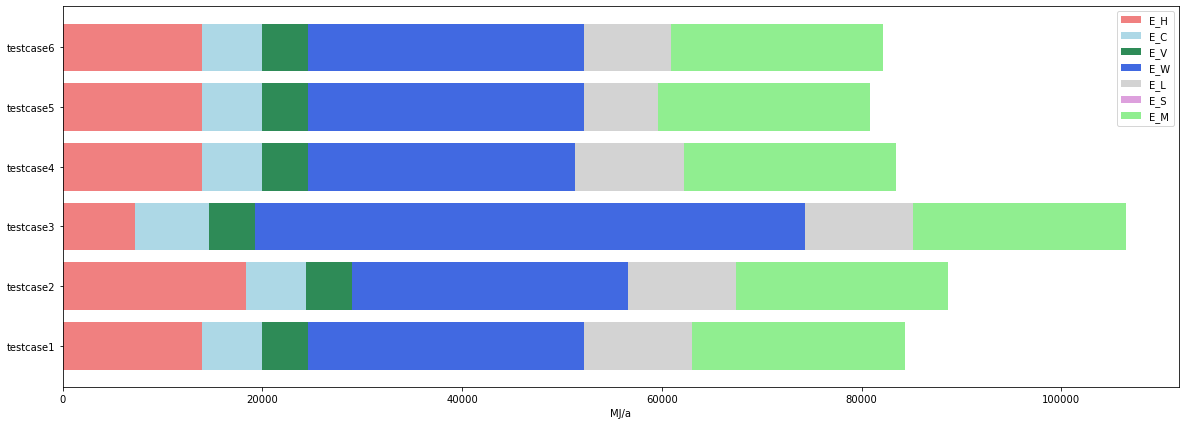

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

DBdict = {'testcase1': res_1, 'testcase2': res_2, 'testcase3': res_3, 'testcase4': res_4, 'testcase5': res_5, 'testcase6': res_6}
DB = pd.DataFrame(DBdict)
print(DB.T)
DB_Ene = DB.T.to_dict()

fig = plt.figure(figsize = (20,7))
grh = fig.add_subplot(111)
grh.set_xlabel('MJ/a')

axNameArr = list(DB_Ene['E_T'].keys())
ayNameArr = ("E_H", "E_C", "E_V", "E_W", "E_L", "E_S", "E_M")
colors = ('lightcoral', 'lightblue', 'seagreen', 'royalblue', 'lightgray', 'plum', 'lightgreen')
left_data = np.zeros(len(axNameArr))

E_Harr = np.array(list(DB_Ene["E_H"].values()))
E_Carr = np.array(list(DB_Ene["E_C"].values()))
E_Varr = np.array(list(DB_Ene["E_V"].values()))
E_Warr = np.array(list(DB_Ene["E_W"].values()))
E_Larr = np.array(list(DB_Ene["E_L"].values()))
E_Sarr = np.array(list(DB_Ene["E_S"].values()))
E_Marr = np.array(list(DB_Ene["E_M"].values()))
EneArr = (E_Harr, E_Carr, E_Varr, E_Warr, E_Larr, E_Sarr, E_Marr)

i=0
for UsageEne in EneArr:
    grh.barh(axNameArr, list(UsageEne), color=colors[i], label=ayNameArr[i], left=left_data)
    left_data += UsageEne
    i += 1

grh.legend()
plt.show()